In [2]:
import numpy as np

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm
from scipy.interpolate import PchipInterpolator
from scipy.signal import savgol_filter

In [3]:
from proteus.config import read_config
from proteus.utils.constants import M_earth, R_earth
import utils.load_grid as lg
import utils.feathers as feathers

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

In [5]:
pgrid_dir = "data/output/l98d_escape27/"
cases = lg.get_cases(pgrid_dir, only_completed=True)
ncases = len(cases)

In [6]:
cnums = [int(s.split("_")[-1]) for s in cases]
print(cnums)
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

transit, eclipse = lg.load_synthobs(cases)

print("Done")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 154, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,

Synthobs: 100%|██████████| 326/326 [01:25<00:00,  3.82it/s]

Done


In [7]:
g24_ts = pd.read_csv("data/reference/l9859/gressier24_transitspectroscopy_d.dat", delimiter=' ')
g24_ts_x = g24_ts["central_wavelength(microns)"]
g24_ts_y = g24_ts["transit_depth"] * 1e6
g24_ts_e = g24_ts["transit_depth_error"] * 1e6

g24_ff = pd.read_csv("data/reference/l9859/gressier24_firefly_d.dat", delimiter=' ')
g24_ff_x = g24_ff["central_wavelength(microns)"]
g24_ff_y = g24_ff["transit_depth"] * 1e6
g24_ff_e = g24_ff["transit_depth_error"] * 1e6

g24_fc = pd.read_csv("data/reference/l9859/gressier24_freechem_d.dat", delimiter=' ')
g24_fc_x = g24_fc["central_wavelength(microns)"]
g24_fc_y = g24_fc["best_fit_transit_depth"] * 1e6
g24_fc_e = g24_fc["1_sigma_uncertainty"] * 1e6

z23 = pd.read_csv("data/reference/l9859/zhou23_hst_d.dat", delimiter=' ')
z23_x = z23["wavelength_um"]
z23_y = z23["obs_transit_depth"] * 1e6
z23_e = z23["obs_transit_depth_error"] * 1e6

In [8]:
tra_x = np.append(z23_x, g24_ff_x)
tra_y = np.append(z23_y, g24_ff_y)

mask = np.argsort(tra_x)
tra_x = tra_x[mask]
tra_y = tra_y[mask]

def synth_itp(synth_x, synth_y):
    itp = PchipInterpolator(synth_x, synth_y)
    return itp(tra_x)

def chi2_itp(obs, exp):
    chi2 = 0.0
    for i in range(len(obs)):
        chi2 += (obs[i] - exp[i])**2 / exp[i]
    return chi2

Included cases: 109
outgas.fO2_shift_IW


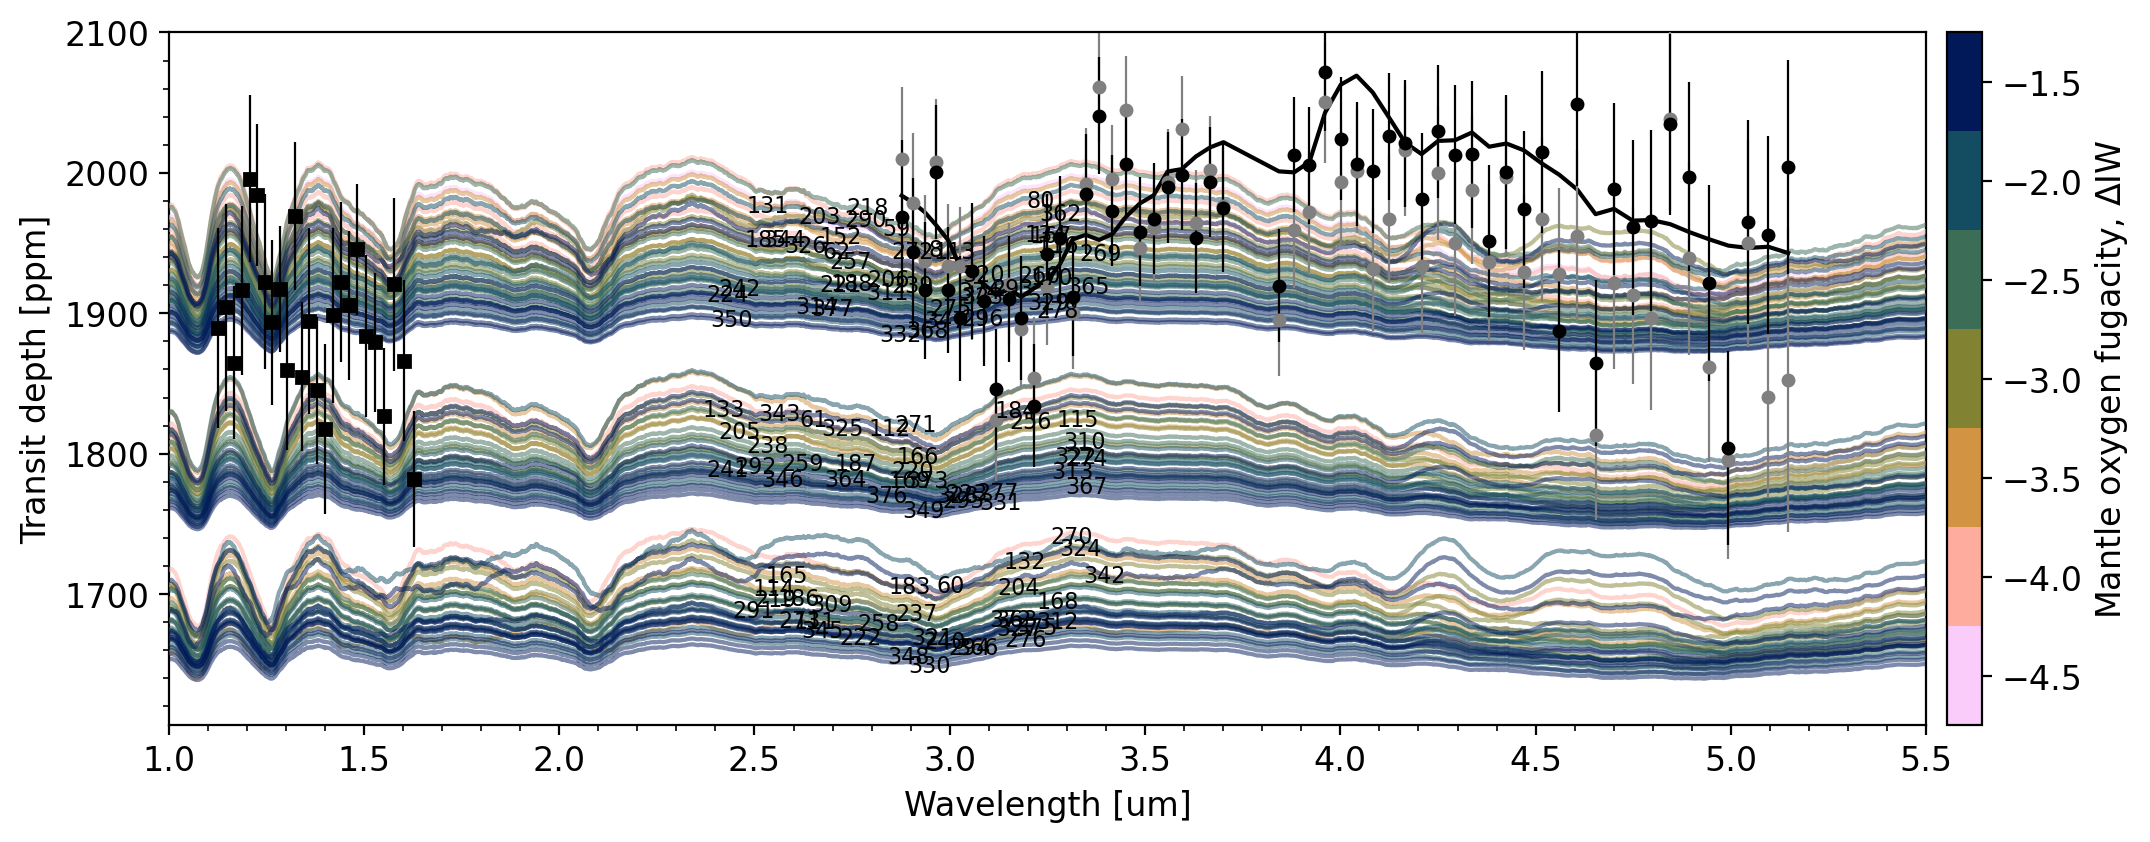

Case	 zval	 Chi2
362	 -1.5	 187.681
320	 -2	 189.437
203	 -3	 193.393
344	 -1.5	 196.957
326	 -1.5	 199.377
269	 -2.5	 200.408
257	 -2.5	 200.86
152	 -3.5	 202.551
206	 -3	 207.199
185	 -3	 207.665
167	 -3	 208.792
134	 -3.5	 209.503
239	 -2.5	 209.62
272	 -2	 210.407
374	 -1.5	 213.425
116	 -3.5	 214.089
 62	 -4	 216.067
311	 -2	 217.013
188	 -3	 219.088
290	 -2	 220.329
113	 -3.5	 220.398
221	 -2.5	 220.557
 80	 -4	 223.998
260	 -2.5	 226.317
323	 -2	 226.446
131	 -3.5	 234.6
170	 -3	 236.527
293	 -2	 238.824
275	 -2	 239.179
242	 -2.5	 242.349
365	 -1.5	 244.064
  8	 -4.5	 245.936
377	 -1.5	 254.054
218	 -2.5	 254.662
224	 -2.5	 257.031
347	 -1.5	 258.45
314	 -2	 258.853
 59	 -4	 264.909
329	 -1.5	 269.738
296	 -2	 279.443
368	 -1.5	 282.284
278	 -2	 290.332
350	 -1.5	 304.244
332	 -1.5	 309.737
271	 -2	 752.869
112	 -3.5	 793.628
343	 -1.5	 849.39
 61	 -4	 879.237
184	 -3	 897.936
325	 -1.5	 906.688
256	 -2.5	 951.189
133	 -3.5	 951.505
166	 -3	 997.218
205	 -3	 1026.77
115	 -3.5	 

In [37]:
figscale = 1.5
fig,ax = plt.subplots(1,1, figsize=(9*figscale,3*figscale))

# zkey = "struct.mass_tot"
# zlbl = r"Planet mass [M$_\oplus$]"
# zfct = 1.0
# cmap = plt.get_cmap("princess_parrot")

# zkey = "delivery.elements.H_ppmw"
# zlbl = r"Initial H inventory, H$_\text{ppmw}$"
# zfct = 1.0
# cmap = plt.get_cmap("eastern_rosella_r")

zkey = "outgas.fO2_shift_IW"
zlbl = r"Mantle oxygen fugacity, $\Delta$IW"
zfct = 1.0
cmap = cm.batlow_r

# zkey = "rho_obs"
# zlbl = r"Observed bulk density, $\rho_p$"
# zfct = 1e-3
# cmap = plt.get_cmap("viridis")

# zkey = "gravity"
# zlbl = "Surface gravity [m s-2]"
# zfct = 1.0
# cmap = plt.get_cmap("viridis")

zscl = "linear"
show_legend = False
show_casenums = True

# controls = {"struct.mass_tot": 2.14}
controls = {}
ykey = "None/ppm"
yvar = transit
ylbl = "Transit depth [ppm]"
dsmp = 2
xlim = (1.0, 5.5)

def get_val(conf, help, key):
    if "." in key:
        z = lg.descend_get(conf, key)
    else:
        z = help[key].iloc[-1]
    return z

# work out which cases match control variables
incl = []
for i in range(ncases):
    is_incl = True

    # check controls
    for k in controls.keys():
        z = get_val(confs[i], helps[i], k)
        if not np.isclose(z,controls[k]):
            is_incl = False

    # check status
    if stts[cnums[i]] != 13:
        is_incl = False

    if is_incl:
        incl.append(i)
print("Included cases: %d"%len(incl))

# get range for zkey
print(zkey)
zvals = []
for i in incl:
    zvals.append(get_val(confs[i], helps[i], zkey)*zfct)
zvals = np.unique(zvals)
if zscl == "log":
    norm = mpl.colors.LogNorm(vmin=zvals[0], vmax=zvals[-1])
else:
    norm = mpl.colors.Normalize(vmin=zvals[0], vmax=zvals[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# plot sims
chi2_arr = []
z_arr = []
rho_arr = []
for i in range(ncases):

    if i not in incl:
        continue

    cfg = confs[i]

    x = np.array(yvar[i]["Wavelength/um"])
    y = np.array(yvar[i][ykey])
    z = get_val(confs[i], helps[i], zkey)

    if len(x) < 2:
        continue

    x_bin = tra_x
    y_bin = synth_itp(x, y)
    # ax.scatter(x_bin, y_bin, color=sm.to_rgba(z), alpha=0.5, zorder=4, marker='s', edgecolor='none', s=10)

    x_smth = np.array(x)
    y_smth = savgol_filter(y, 200, 5)
    ax.plot(x_smth, y_smth, color=sm.to_rgba(z), alpha=0.5, zorder=3)

    if show_casenums:
        wl_idx = np.argmin(np.abs(x_smth - 2.4 - 1*np.random.rand())) # placement of text
        x = x_smth[wl_idx]
        y = y_smth[wl_idx]
        fs = 8
        ax.text(x,y,str(cnums[i]), fontsize=fs, color='k', zorder=9, horizontalalignment='center', verticalalignment='center')

    rho_arr.append(helps[i]["rho_obs"].iloc[-1])
    z_arr.append(z)
    chi2_arr.append(chi2_itp(y_bin, tra_y))

# plot literature
ax.errorbar(z23_x, z23_y, yerr=z23_e, label="Zhou+23 (HST)", color="black",
                zorder=4, fmt='s', markersize=4, elinewidth=0.8)
ax.plot(g24_fc_x, g24_fc_y, label="Gressier+24 (Best fit)", color="black", zorder=4,)
ax.errorbar(g24_ts_x, g24_ts_y, yerr=g24_ts_e, label="Gressier+24 (TS pipeline)", color="grey",
                zorder=4, fmt='o',  markersize=4, elinewidth=0.8)
ax.errorbar(g24_ff_x, g24_ff_y, yerr=g24_ff_e, label="Gressier+24 (FF pipeline)", color="black",
                zorder=4, fmt='o',  markersize=4, elinewidth=0.8)


ax.set(xlabel="Wavelength [um]", xlim=xlim)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_ylabel(ylbl)
ax.set_ylim(top=2100)
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(20))

cbpad = 0.01
if len(zvals) > 7:
    fig.colorbar(sm, ax=ax, label=zlbl,  pad=cbpad,)
else:
    fig.colorbar(sm, ax=ax, label=zlbl, values=zvals, ticks=zvals,  pad=cbpad,)
if show_legend:
    ax.legend(loc='lower center', ncols=2)
plt.show()
fig.savefig("output/transit.pdf", bbox_inches='tight')


print("Case\t zval\t Chi2")
for j in np.argsort(chi2_arr):
    print("%3d\t %g\t %g"%(cnums[incl[j]], z_arr[j], chi2_arr[j]))